First attempt at pulling data from Kaggle and recoding categorical variables of interest into dummy variables.

In [7]:
%matplotlib inline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Structure
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Others
from datetime import datetime
import zipfile

# Import Data

In [2]:
# Load the data and examine it
crime_data = pd.read_csv("./train.csv")
print "Shape of crime_data:", crime_data.shape
crime_data.head()

Shape of crime_data: (878049, 9)


Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [3]:
test_data = pd.read_csv("./test.csv")
print "Shape of test_data:", test_data.shape
test_data.head()

Shape of test_data: (884262, 7)


Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

# Data Exploratory

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


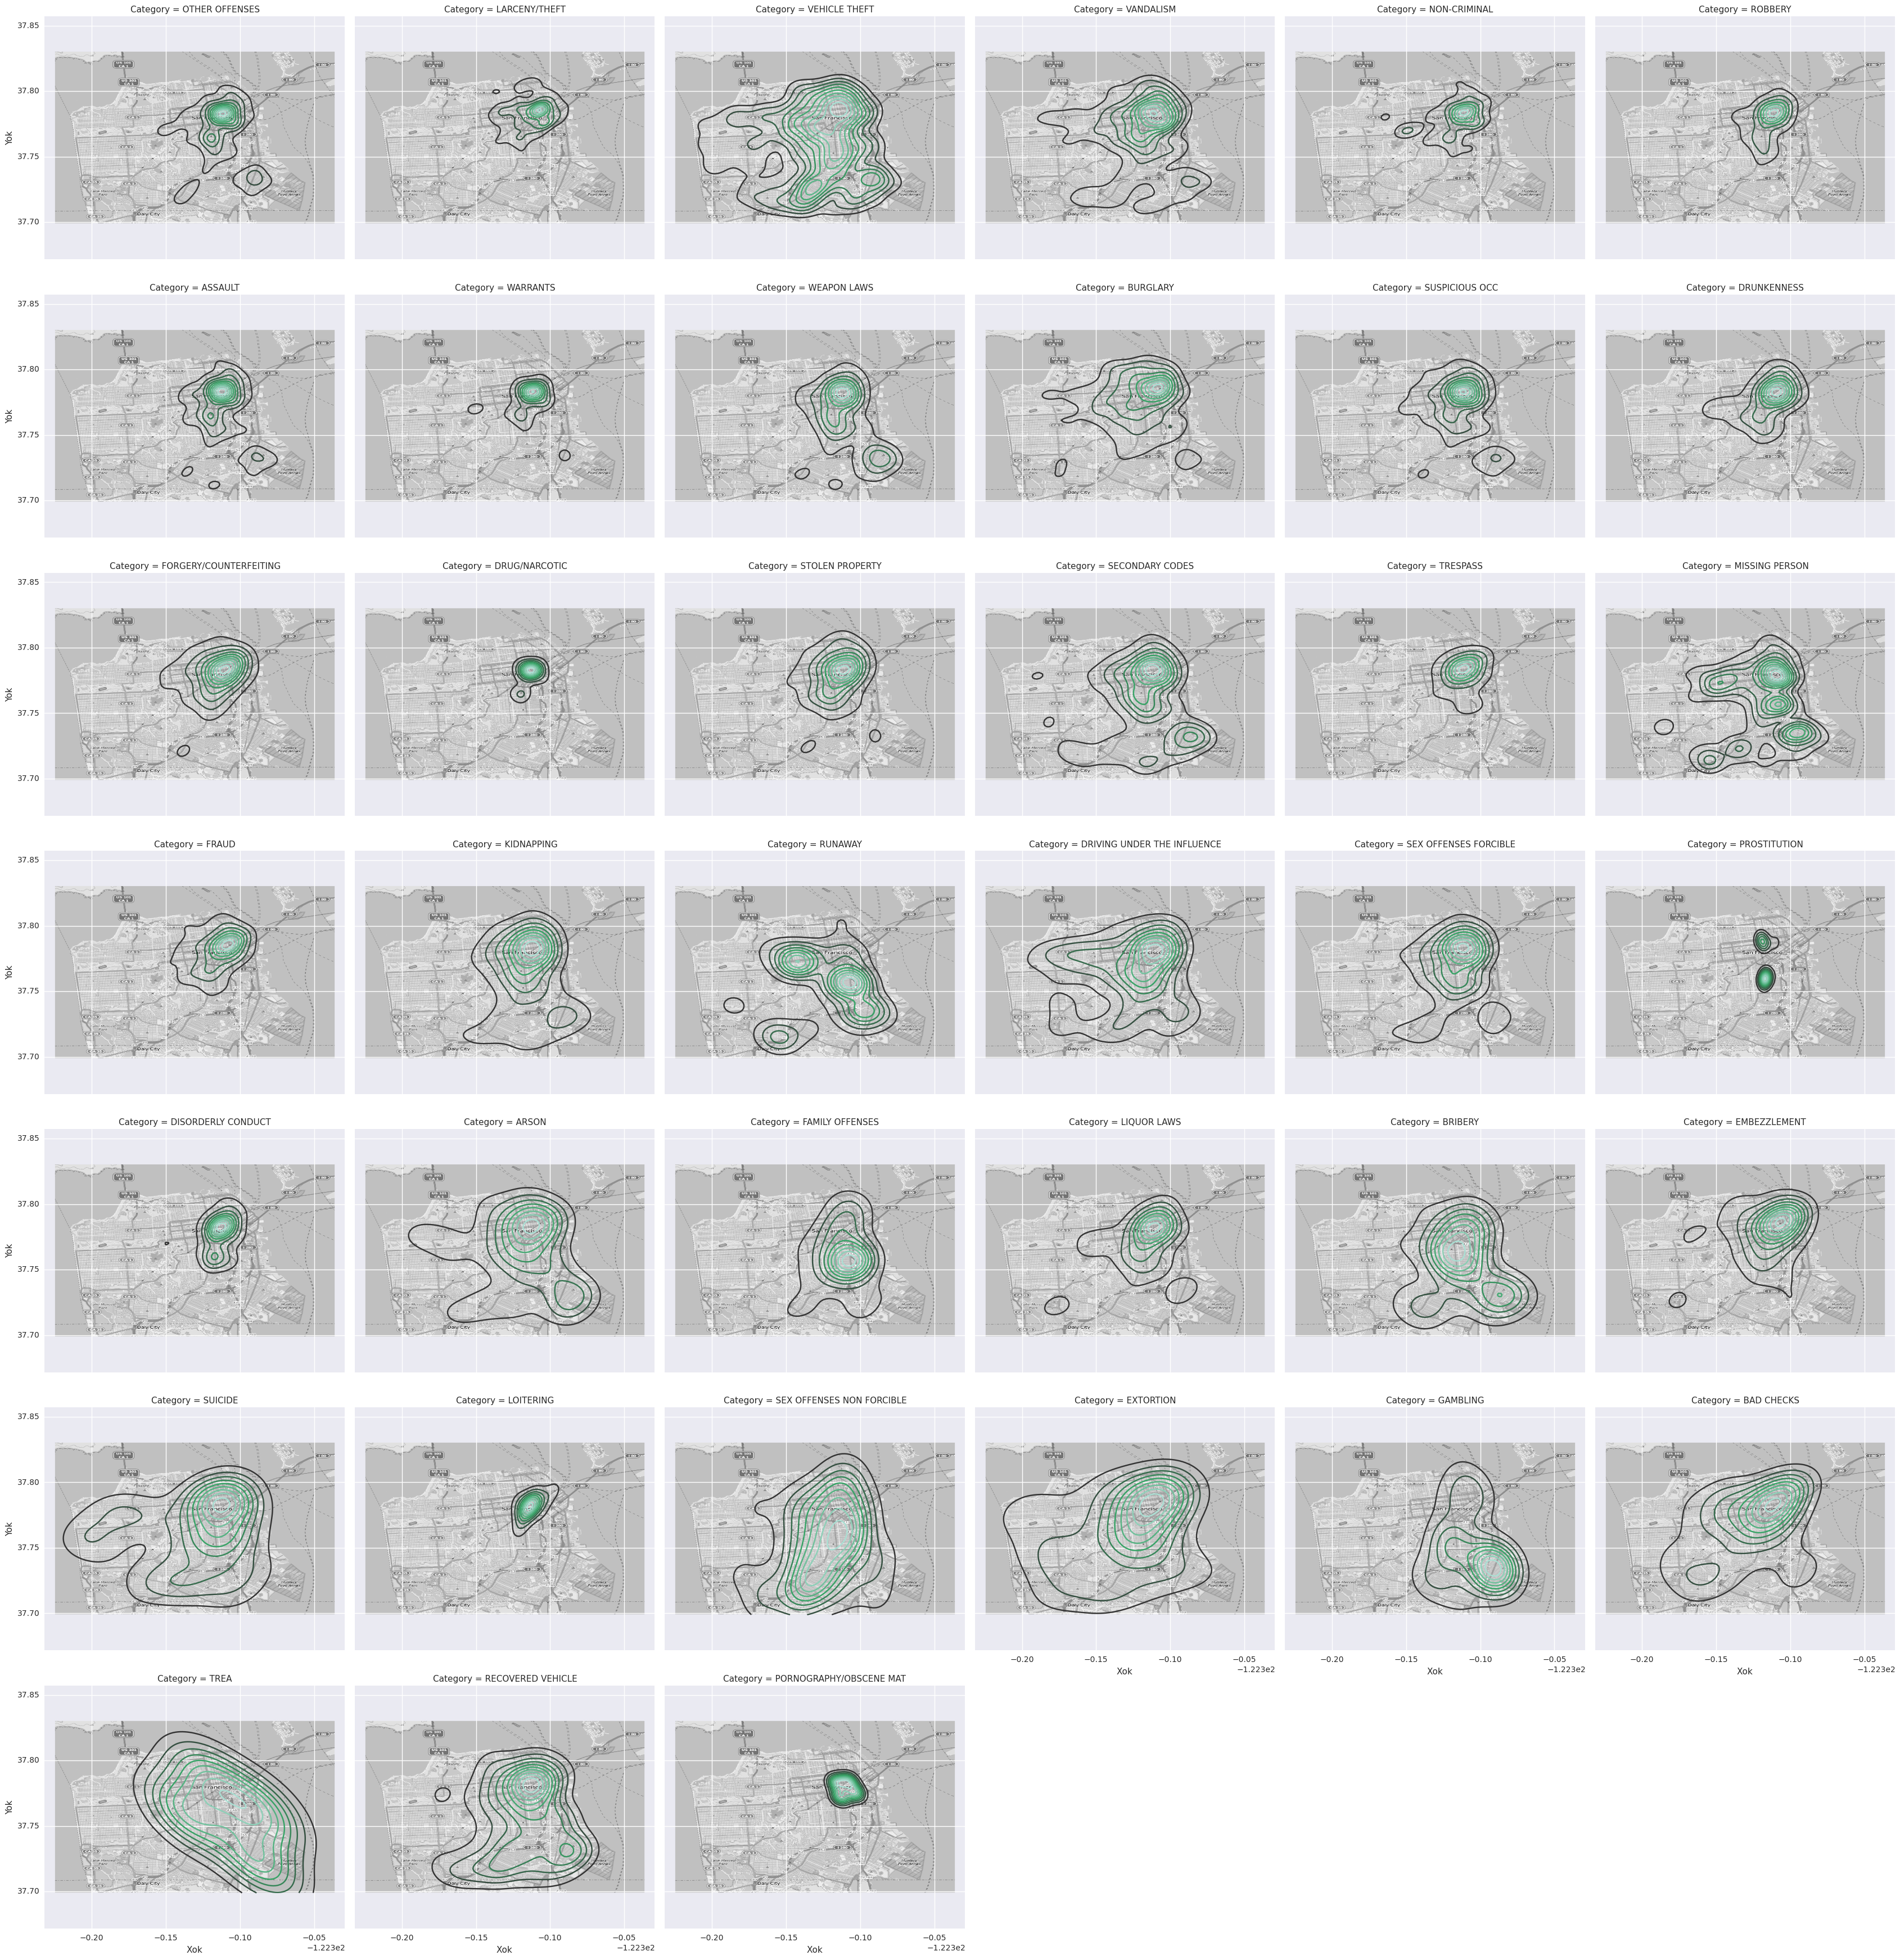

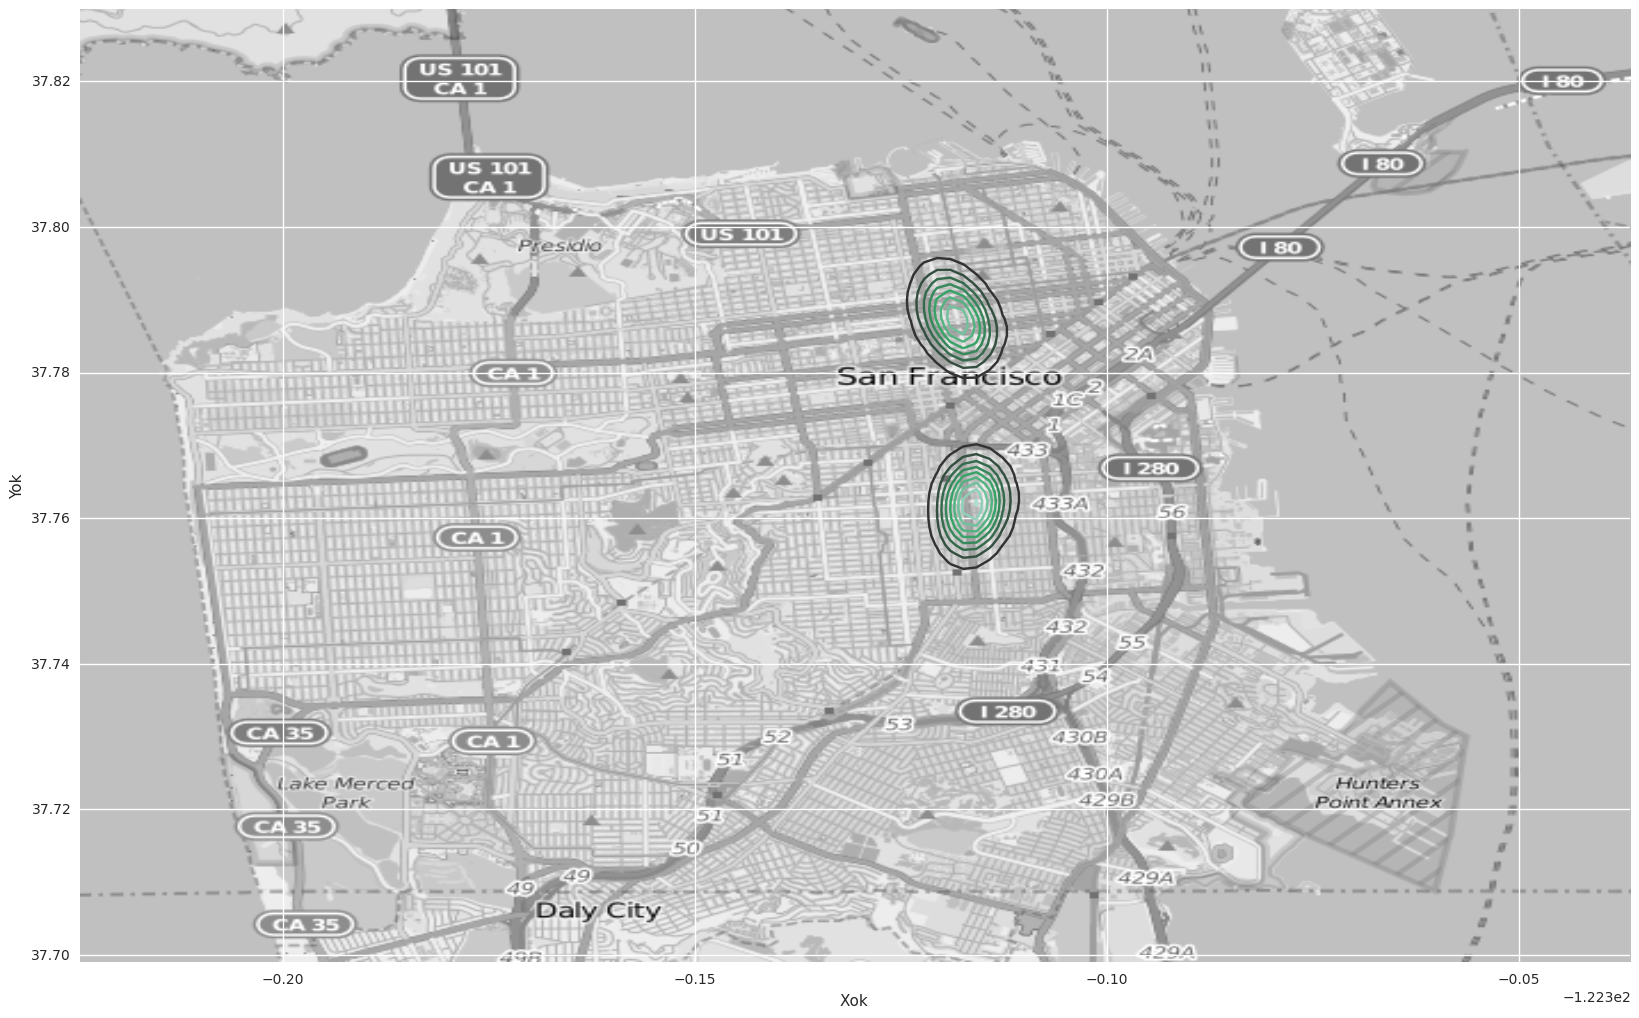

In [9]:
# Supplied map bounding box:
#    ll.lon     ll.lat   ur.lon     ur.lat
#    -122.52469 37.69862 -122.33663 37.82986
mapdata = np.loadtxt("./sf_map_copyright_openstreetmap_contributors.txt")
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

z = zipfile.ZipFile('./train.csv.zip')
train = pd.read_csv(z.open('train.csv'))

#Get rid of the bad lat/longs
train['Xok'] = train[train.X<-121].X
train['Yok'] = train[train.Y<40].Y
train = train.dropna()
train = train[1:300000] #Can't use all the data and complete within 600 sec :(

#Seaborn FacetGrid, split by crime Category
g= sns.FacetGrid(train, col="Category", col_wrap=6, size=5, aspect=1/asp)

#Show the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
#Kernel Density Estimate plot
g.map(sns.kdeplot, "Xok", "Yok", clip=clipsize)

plt.savefig('category_density_plot.png')

#Do a larger plot with prostitution only
plt.figure(figsize=(20,20*asp))
ax = sns.kdeplot(trainP.Xok, trainP.Yok, clip=clipsize, aspect=1/asp)
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
plt.savefig('prostitution_density_plot.png')

In [4]:
# At the second step, we want to see the basic info of our data.
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [5]:
# Show all available crime lables.
print crime_data['Category'].value_counts()

# Show the percentage of the mode in all data. If the prediction of the model is worse than always predicting the mode,
# then we should always predict the mode in the baseline establishment.
print 'The percentage of the LARCENY/THEFT is: ', crime_data['Category'].value_counts()[0] * 1.0 / crime_data.shape[0]

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [6]:
# Convert the date into a python datetime object.
crime_data["Dates"] = pd.to_datetime(crime_data["Dates"], format="%Y-%m-%d %H:%M:%S")
test_data["Dates"] = pd.to_datetime(test_data["Dates"], format="%Y-%m-%d %H:%M:%S")

In [7]:
# Add 24 binary features representing the happening hour of the crime.
hour_map = {0:'Zero', 1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine', 
            10:'Ten', 11:'Eleven', 12:'Twelve', 13:'Thirteen', 14:'Fourteen', 15:'Fifteen', 16:'Sixteen', 
            17:'Seventeen', 18:'Eighteen', 19:'Nineteen', 20:'Twenty', 21:'TwentyOne', 22:'TwentyTwo', 
            23:'TwentyThree'}

crime_data["Hour"] = crime_data["Dates"].apply(lambda x: x.hour)
for hour in crime_data["Hour"].unique():
    crime_data[hour_map[hour]] = pd.Series(crime_data["Hour"] == hour, dtype=int)
     
test_data["Hour"] = test_data["Dates"].apply(lambda x: x.hour)
for hour in test_data["Hour"].unique():
    test_data[hour_map[hour]] = pd.Series(test_data["Hour"] == hour, dtype=int)
    
crime_data.iloc[:5,-24:]

TwentyThree  TwentyTwo  TwentyOne  Twenty  Nineteen  Eighteen  Seventeen  \
0            1          0          0       0         0         0          0   
1            1          0          0       0         0         0          0   
2            1          0          0       0         0         0          0   
3            1          0          0       0         0         0          0   
4            1          0          0       0         0         0          0   

   Sixteen  Fifteen  Fourteen  ...   Nine  Eight  Seven  Six  Five  Four  \
0        0        0         0  ...      0      0      0    0     0     0   
1        0        0         0  ...      0      0      0    0     0     0   
2        0        0         0  ...      0      0      0    0     0     0   
3        0        0         0  ...      0      0      0    0     0     0   
4        0        0         0  ...      0      0      0    0     0     0   

   Three  Two  One  Zero  
0      0    0    0     0  
1      0    0    0     0  
2      0    0    0     0  
3      0    0    0     0  
4      0    0    0     0  

[5 rows x 24 columns]

In [8]:
# Add 12 binary features representing the happening month of the crime.
month_map = {1:'January', 2:'February ', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September',
             10:'October', 11:'November', 12:'December'}

crime_data["Month"] = crime_data["Dates"].apply(lambda x: x.month)
for month in crime_data["Month"].unique():
    crime_data[month_map[month]] = pd.Series(crime_data["Month"] == month, dtype=int)
    
test_data["Month"] = test_data["Dates"].apply(lambda x: x.month)
for month in test_data["Month"].unique():
    test_data[month_map[month]] = pd.Series(test_data["Month"] == month, dtype=int)
    
crime_data.iloc[:5,-12:]

May  April  March  February   January  December  November  October  \
0    1      0      0          0        0         0         0        0   
1    1      0      0          0        0         0         0        0   
2    1      0      0          0        0         0         0        0   
3    1      0      0          0        0         0         0        0   
4    1      0      0          0        0         0         0        0   

   September  August  July  June  
0          0       0     0     0  
1          0       0     0     0  
2          0       0     0     0  
3          0       0     0     0  
4          0       0     0     0

In [9]:
# Add 12 binary features representing the happening year of the crime.
crime_data["Year"] = crime_data["Dates"].apply(lambda x: x.year)
for year in crime_data["Year"].unique():
    crime_data[year] = pd.Series(crime_data["Year"] == year, dtype=int)
    
test_data["Year"] = test_data["Dates"].apply(lambda x: x.year)
for year in test_data["Year"].unique():
    test_data[year] = pd.Series(test_data["Year"] == year, dtype=int)

crime_data.iloc[:5,-13:]

2015  2014  2013  2012  2011  2010  2009  2008  2007  2006  2005  2004  \
0     1     0     0     0     0     0     0     0     0     0     0     0   
1     1     0     0     0     0     0     0     0     0     0     0     0   
2     1     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     0     0     0     0     0     0   
4     1     0     0     0     0     0     0     0     0     0     0     0   

   2003  
0     0  
1     0  
2     0  
3     0  
4     0

In [10]:
# Add 7 binary features representing the happening date of week of the crime.
for day_of_week in crime_data["DayOfWeek"].unique():
    crime_data[day_of_week] = pd.Series(crime_data["DayOfWeek"] == day_of_week, dtype=int)
    
for day_of_week in test_data["DayOfWeek"].unique():
    test_data[day_of_week] = pd.Series(test_data["DayOfWeek"] == day_of_week, dtype=int)
    
# Add 10 binary features representing the district of the crime.
for district in crime_data["PdDistrict"].unique():
    crime_data[district] = pd.Series(crime_data["PdDistrict"] == district, dtype=int)
    
for district in test_data["PdDistrict"].unique():
    test_data[district] = pd.Series(test_data["PdDistrict"] == district, dtype=int)

In [12]:
# Normalize X and Y
x_mean = crime_data["X"].mean()
x_std = crime_data["X"].std()
y_mean = crime_data["Y"].mean()
y_std = crime_data["Y"].std()
crime_data['X'] = crime_data["X"].apply(lambda x: (x - x_mean) /  x_std).round(3)
crime_data['Y'] = crime_data["Y"].apply(lambda y: (y - y_mean) /  y_std).round(3)

x_mean = test_data["X"].mean()
x_std = test_data["X"].std()
y_mean = test_data["Y"].mean()
y_std = test_data["Y"].std()
test_data['X'] = test_data["X"].apply(lambda x: (x - x_mean) /  x_std).round(3)
test_data['Y'] = test_data["Y"].apply(lambda y: (y - y_mean) /  y_std).round(3)

crime_data.describe()

X              Y           Hour    TwentyThree  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean       -0.000009       0.000017      13.412655       0.048357   
std         1.000004       0.999997       6.549573       0.214520   
min        -2.999000      -0.138000       0.000000       0.000000   
25%        -0.340000      -0.041000       9.000000       0.000000   
50%         0.204000       0.010000      14.000000       0.000000   
75%         0.516000       0.029000      19.000000       0.000000   
max        63.341000     114.313000      23.000000       1.000000   

           TwentyTwo      TwentyOne         Twenty       Nineteen  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean        0.052094       0.049725       0.050901       0.056347   
std         0.222217       0.217376       0.219797       0.230590   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            Eighteen      Seventeen      ...             NORTHERN  \
count  878049.000000  878049.000000      ...        878049.000000   
mean        0.062757       0.060991      ...             0.119920   
std         0.242526       0.239314      ...             0.324869   
min         0.000000       0.000000      ...             0.000000   
25%         0.000000       0.000000      ...             0.000000   
50%         0.000000       0.000000      ...             0.000000   
75%         0.000000       0.000000      ...             0.000000   
max         1.000000       1.000000      ...             1.000000   

                PARK      INGLESIDE        BAYVIEW       RICHMOND  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean        0.056162       0.089796       0.101852       0.051488   
std         0.230234       0.285889       0.302454       0.220991   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             CENTRAL        TARAVAL     TENDERLOIN        MISSION  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean        0.097329       0.074707       0.093171       0.136562   
std         0.296406       0.262917       0.290673       0.343384   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            SOUTHERN  
count  878049.000000  
mean        0.179013  
std         0.383363  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 71 columns]

In [13]:
# Drop the unnecessary feature columns from the train data.
crime_data = crime_data.drop(['Hour', 'Month', 'Year', 'Dates', 'DayOfWeek', 'PdDistrict', 
                              'Descript', 'Resolution', 'Address'], axis=1)
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 69 columns):
Category       878049 non-null object
X              878049 non-null float64
Y              878049 non-null float64
TwentyThree    878049 non-null int32
TwentyTwo      878049 non-null int32
TwentyOne      878049 non-null int32
Twenty         878049 non-null int32
Nineteen       878049 non-null int32
Eighteen       878049 non-null int32
Seventeen      878049 non-null int32
Sixteen        878049 non-null int32
Fifteen        878049 non-null int32
Fourteen       878049 non-null int32
Thirteen       878049 non-null int32
Twelve         878049 non-null int32
Eleven         878049 non-null int32
Ten            878049 non-null int32
Nine           878049 non-null int32
Eight          878049 non-null int32
Seven          878049 non-null int32
Six            878049 non-null int32
Five           878049 non-null int32
Four           878049 non-null int32
Three          878049 non-null in

In [14]:
# Before we train the models, we need to divide the data into train data and dev data.
shuffle = np.random.permutation(np.arange(crime_data.shape[0]))

crime_data = crime_data.iloc[shuffle]

train_data = crime_data.drop('Category', axis=1)
train_labels = crime_data['Category']

mini_train_data = crime_data.iloc[:10000].drop('Category', axis=1)
mini_train_labels = crime_data.iloc[:10000]['Category']

mini_dev_data = crime_data.iloc[10000:11000].drop('Category', axis=1)
mini_dev_labels = crime_data.iloc[10000:11000]['Category']

print crime_data.shape, train_data.shape, train_labels.shape
print mini_train_data.shape, mini_train_labels.shape, mini_dev_data.shape, mini_dev_labels.shape

(878049, 69) (878049, 68) (878049L,)
(10000, 68) (10000L,) (1000, 68) (1000L,)


In [15]:
# Now we train some most common models to see the performance.

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(mini_train_data, mini_train_labels)
pred_labels = logreg.predict(mini_dev_data)
logreg_accuracy = np.mean(mini_dev_labels == pred_labels)

# Support Vector Machines
svc = SVC()
svc.fit(mini_train_data, mini_train_labels)
pred_labels = svc.predict(mini_dev_data)
svc_accuracy = np.mean(mini_dev_labels == pred_labels)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(mini_train_data, mini_train_labels)
pred_labels = knn.predict(mini_dev_data)
knn_accuracy = np.mean(mini_dev_labels == pred_labels)

# Naive Bayes
gaussian = GaussianNB()
gaussian.fit(mini_train_data, mini_train_labels)
pred_labels = gaussian.predict(mini_dev_data)
nb_accuracy = np.mean(mini_dev_labels == pred_labels)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(mini_train_data, mini_train_labels)
pred_labels = decision_tree.predict(mini_dev_data)
dt_accuracy = np.mean(mini_dev_labels == pred_labels)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(mini_train_data, mini_train_labels)
pred_labels = random_forest.predict(mini_dev_data)
rf_accuracy = np.mean(mini_dev_labels == pred_labels)

# Neural Network
ann = MLPClassifier()
ann.fit(mini_train_data, mini_train_labels)
pred_labels = ann.predict(mini_dev_data)
ann_accuracy = np.mean(mini_dev_labels == pred_labels)

# Display the rank of the models
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Neural Network', 'Decision Tree'],
    'Accuracy': [svc_accuracy, knn_accuracy, logreg_accuracy, 
              rf_accuracy, nb_accuracy, ann_accuracy, dt_accuracy]})
models.sort_values(by='Accuracy', ascending=False)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Accuracy                    Model
3     0.215            Random Forest
2     0.210      Logistic Regression
0     0.201  Support Vector Machines
5     0.164           Neural Network
6     0.157            Decision Tree
1     0.122                      KNN
4     0.005              Naive Bayes

In [18]:
# We will use the Random Forest to establish the baseline.

# Retrain the Random Forest model with full train data
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [19]:
# Import the test data and use the selected model to predict
test_pred = logreg.predict(test_data.drop(['Hour', 'Month', 'Year', 'Dates', 'DayOfWeek', 'PdDistrict', 
                            'Id', 'Address'], axis=1))

In [20]:
# Save the prediction data to a csv file.

id_column = np.array(range(test_pred.shape[0]), dtype=int)
np_matrix = np.column_stack((id_column, test_pred))
df = pd.DataFrame(data=np_matrix, columns=['Id', 'Category'])

# Transform the np matrix to a dataframe compliant with the submission standard 
for crime in df["Category"].unique():
    df[crime] = pd.Series(df["Category"] == crime, dtype=int)
    
# Add columns for crime appearing in the train data but not the prediction data
for crime in crime_data['Category'].unique():
    if crime not in df:
        df[crime] = pd.Series([0] * test_pred.shape[0], dtype=int)
    
# Rearrange the columns in lexical order to comply with the submission format
df = df.reindex_axis([df.columns[0]] + sorted(df.columns[1:]), axis=1)

# Drop the unnecessary column
df = df.drop('Category', axis=1)
df.info()

# Save the submission file locally
df.to_csv('./submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 40 columns):
Id                             884262 non-null object
ARSON                          884262 non-null int32
ASSAULT                        884262 non-null int32
BAD CHECKS                     884262 non-null int32
BRIBERY                        884262 non-null int32
BURGLARY                       884262 non-null int32
DISORDERLY CONDUCT             884262 non-null int32
DRIVING UNDER THE INFLUENCE    884262 non-null int32
DRUG/NARCOTIC                  884262 non-null int32
DRUNKENNESS                    884262 non-null int32
EMBEZZLEMENT                   884262 non-null int32
EXTORTION                      884262 non-null int32
FAMILY OFFENSES                884262 non-null int32
FORGERY/COUNTERFEITING         884262 non-null int32
FRAUD                          884262 non-null int32
GAMBLING                       884262 non-null int32
KIDNAPPING                     884262 no